In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [34]:
X_train=np.genfromtxt('./data/clean/train_clean_feats.csv',delimiter=',')
y_train=np.genfromtxt('./data/clean/train_clean_labels.csv',delimiter=',')

X_val=np.genfromtxt('./data/clean/val_clean_feats.csv',delimiter=',')
y_val=np.genfromtxt('./data/clean/val_clean_labels.csv',delimiter=',')

X_test=np.genfromtxt('./data/clean/test_clean_feats.csv',delimiter=',')
y_test=np.genfromtxt('./data/clean/test_clean_labels.csv',delimiter=',')

In [35]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [36]:
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [116]:
def train_test_model(model,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val):
    model.fit(X_train,y_train)
    y_pred_val=model.predict(X_val)
    print(classification_report(y_val,y_pred_val))

def test_model(model,X_test=X_test,y_test=y_test):
    y_pred=model.predict(X_test)
    print(classification_report(y_test,y_pred))
    
def test_model_nn(model,X_test=X_test,y_test=y_test):
    y_pred=model(X_test)
    y_pred=torch.argmax(y_pred,axis=1)
    print(classification_report(y_test.detach().numpy(),y_pred.detach().numpy()))

def gen_final_result(model,scaler):
    df_test=pd.read_csv('./data/test.csv')
    idx=df_test['PassengerId']
    X_test_final=np.genfromtxt('./data/clean/final_test_set.csv',delimiter=',')
    X_test_final=scaler.transform(X_test_final)
    y_pred=model.predict(X_test_final)
    print(y_pred)
    y_pred=y_pred.astype('bool')
    df=pd.DataFrame(y_pred,index=idx.values,columns=['Transported'])
    df.index.name='PassengerId'
    df.to_csv('./submission.csv')

def gen_final_result_nn(model,scaler):
    df_test=pd.read_csv('./data/test.csv')
    idx=df_test['PassengerId']
    X_test_final=np.genfromtxt('./data/clean/final_test_set.csv',delimiter=',')
    X_test_final=scaler.transform(X_test_final)
    y_pred=model(torch.Tensor(X_test_final))
    y_pred=torch.argmax(y_pred,axis=1)
    y_pred=y_pred.detach().numpy()
    print(y_pred)
    y_pred=y_pred.astype('bool')
    df=pd.DataFrame(y_pred,index=idx.values,columns=['Transported'])
    df.index.name='PassengerId'
    df.to_csv('./submission.csv')

In [67]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()
train_test_model(model)

              precision    recall  f1-score   support

         0.0       0.78      0.77      0.77       231
         1.0       0.74      0.75      0.74       204

    accuracy                           0.76       435
   macro avg       0.76      0.76      0.76       435
weighted avg       0.76      0.76      0.76       435



In [68]:
test_model(model)

              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77       224
         1.0       0.75      0.79      0.77       211

    accuracy                           0.77       435
   macro avg       0.77      0.77      0.77       435
weighted avg       0.77      0.77      0.77       435



In [66]:
gen_final_result(model,scaler)

[1. 0. 1. ... 1. 1. 1.]


In [69]:
import torch
import torch.nn as nn

In [72]:
class TabularModel(nn.Module):
    def __init__(self,input_size,output_size,layers,p=0.2):
        super().__init__()
        
        layer_list=[]
        for i in layers:
            layer_list.append(nn.Linear(input_size,i))
            layer_list.append(nn.LeakyReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            input_size=i
        
        layer_list.append(nn.Linear(layers[-1],output_size))
        
        self.layers=nn.Sequential(*layer_list)
    
    def forward(self,x):
        x=self.layers(x)
        return x

In [102]:
model=TabularModel(23,2,[23,64,64,32],0.2)

In [103]:
X_train=torch.Tensor(X_train)
y_train=torch.Tensor(y_train)

X_val=torch.Tensor(X_val)
y_val=torch.Tensor(y_val)

X_test=torch.Tensor(X_test)
y_test=torch.Tensor(y_test)

In [104]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.01)

In [105]:
Epochs=50
training_loss=[]
validation_loss=[]
for epoch in range(1,Epochs+1):
    optimizer.zero_grad()
    
    y_pred=model(X_train)
    loss=criterion(y_pred,torch.tensor(y_train,dtype=torch.int64))
    val_loss=criterion(model(X_val),torch.tensor(y_val,dtype=torch.int64))
    print(f'Epoch {epoch}/Epochs\tLoss {loss.item():0.5f}\tValidation Loss {val_loss.item():0.5f}')
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    loss.backward()
    optimizer.step()
    

C:\Users\ADVAIT~1\AppData\Local\Temp/ipykernel_26652/1879366023.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss=criterion(y_pred,torch.tensor(y_train,dtype=torch.int64))
C:\Users\ADVAIT~1\AppData\Local\Temp/ipykernel_26652/1879366023.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss=criterion(model(X_val),torch.tensor(y_val,dtype=torch.int64))


Epoch 1/Epochs	Loss 0.78593	Validation Loss 0.76111
Epoch 2/Epochs	Loss 0.74610	Validation Loss 0.72130
Epoch 3/Epochs	Loss 0.70608	Validation Loss 0.72818
Epoch 4/Epochs	Loss 0.68671	Validation Loss 0.70038
Epoch 5/Epochs	Loss 0.67177	Validation Loss 0.66127
Epoch 6/Epochs	Loss 0.65348	Validation Loss 0.62866
Epoch 7/Epochs	Loss 0.63953	Validation Loss 0.65459
Epoch 8/Epochs	Loss 0.62300	Validation Loss 0.63544
Epoch 9/Epochs	Loss 0.62332	Validation Loss 0.65234
Epoch 10/Epochs	Loss 0.61254	Validation Loss 0.59748
Epoch 11/Epochs	Loss 0.59950	Validation Loss 0.61830
Epoch 12/Epochs	Loss 0.59558	Validation Loss 0.59346
Epoch 13/Epochs	Loss 0.59022	Validation Loss 0.60815
Epoch 14/Epochs	Loss 0.58716	Validation Loss 0.61555
Epoch 15/Epochs	Loss 0.58237	Validation Loss 0.61447
Epoch 16/Epochs	Loss 0.57467	Validation Loss 0.58194
Epoch 17/Epochs	Loss 0.57650	Validation Loss 0.59751
Epoch 18/Epochs	Loss 0.57050	Validation Loss 0.56855
Epoch 19/Epochs	Loss 0.56007	Validation Loss 0.58329
Ep

Epoch 156/Epochs	Loss 0.41632	Validation Loss 0.42056
Epoch 157/Epochs	Loss 0.41808	Validation Loss 0.44364
Epoch 158/Epochs	Loss 0.41404	Validation Loss 0.43078
Epoch 159/Epochs	Loss 0.41673	Validation Loss 0.44966
Epoch 160/Epochs	Loss 0.41324	Validation Loss 0.43820
Epoch 161/Epochs	Loss 0.41841	Validation Loss 0.44138
Epoch 162/Epochs	Loss 0.41783	Validation Loss 0.43489
Epoch 163/Epochs	Loss 0.41905	Validation Loss 0.42396
Epoch 164/Epochs	Loss 0.41088	Validation Loss 0.41770
Epoch 165/Epochs	Loss 0.41276	Validation Loss 0.43938
Epoch 166/Epochs	Loss 0.41307	Validation Loss 0.44692
Epoch 167/Epochs	Loss 0.41376	Validation Loss 0.44059
Epoch 168/Epochs	Loss 0.41315	Validation Loss 0.44404
Epoch 169/Epochs	Loss 0.41420	Validation Loss 0.45430
Epoch 170/Epochs	Loss 0.41031	Validation Loss 0.42222
Epoch 171/Epochs	Loss 0.40843	Validation Loss 0.43432
Epoch 172/Epochs	Loss 0.41272	Validation Loss 0.43978
Epoch 173/Epochs	Loss 0.41111	Validation Loss 0.44158
Epoch 174/Epochs	Loss 0.4087

Epoch 310/Epochs	Loss 0.39071	Validation Loss 0.42148
Epoch 311/Epochs	Loss 0.38805	Validation Loss 0.40667
Epoch 312/Epochs	Loss 0.38804	Validation Loss 0.42874
Epoch 313/Epochs	Loss 0.38457	Validation Loss 0.42561
Epoch 314/Epochs	Loss 0.38517	Validation Loss 0.42752
Epoch 315/Epochs	Loss 0.38630	Validation Loss 0.41467
Epoch 316/Epochs	Loss 0.38866	Validation Loss 0.43259
Epoch 317/Epochs	Loss 0.38566	Validation Loss 0.41974
Epoch 318/Epochs	Loss 0.39184	Validation Loss 0.42302
Epoch 319/Epochs	Loss 0.38607	Validation Loss 0.41341
Epoch 320/Epochs	Loss 0.38796	Validation Loss 0.42208
Epoch 321/Epochs	Loss 0.38760	Validation Loss 0.41479
Epoch 322/Epochs	Loss 0.38954	Validation Loss 0.41184
Epoch 323/Epochs	Loss 0.38551	Validation Loss 0.41906
Epoch 324/Epochs	Loss 0.39107	Validation Loss 0.43455
Epoch 325/Epochs	Loss 0.38537	Validation Loss 0.41155
Epoch 326/Epochs	Loss 0.38688	Validation Loss 0.43666
Epoch 327/Epochs	Loss 0.38439	Validation Loss 0.42176
Epoch 328/Epochs	Loss 0.3836

Epoch 465/Epochs	Loss 0.37360	Validation Loss 0.39602
Epoch 466/Epochs	Loss 0.37270	Validation Loss 0.40725
Epoch 467/Epochs	Loss 0.37602	Validation Loss 0.42511
Epoch 468/Epochs	Loss 0.37144	Validation Loss 0.42605
Epoch 469/Epochs	Loss 0.37664	Validation Loss 0.41454
Epoch 470/Epochs	Loss 0.37574	Validation Loss 0.39422
Epoch 471/Epochs	Loss 0.37575	Validation Loss 0.42317
Epoch 472/Epochs	Loss 0.37304	Validation Loss 0.39406
Epoch 473/Epochs	Loss 0.37213	Validation Loss 0.41112
Epoch 474/Epochs	Loss 0.37490	Validation Loss 0.40769
Epoch 475/Epochs	Loss 0.37369	Validation Loss 0.41133
Epoch 476/Epochs	Loss 0.37194	Validation Loss 0.40932
Epoch 477/Epochs	Loss 0.37440	Validation Loss 0.41712
Epoch 478/Epochs	Loss 0.37871	Validation Loss 0.42049
Epoch 479/Epochs	Loss 0.37206	Validation Loss 0.43646
Epoch 480/Epochs	Loss 0.37310	Validation Loss 0.43621
Epoch 481/Epochs	Loss 0.37402	Validation Loss 0.40667
Epoch 482/Epochs	Loss 0.37430	Validation Loss 0.39276
Epoch 483/Epochs	Loss 0.3729

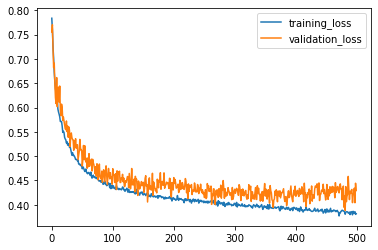

In [101]:
plt.plot(training_loss,label='training_loss')
plt.plot(validation_loss,label='validation_loss')

plt.legend()

In [115]:
gen_final_result_nn(model,scaler)

[1 0 1 ... 1 1 1]


In [117]:
test_model_nn(model)

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83       224
         1.0       0.81      0.82      0.82       211

    accuracy                           0.82       435
   macro avg       0.82      0.82      0.82       435
weighted avg       0.82      0.82      0.82       435

